Input sized of EfficientNet variants

For B0 to B7 base models, the input shapes are different. Here is a list of input shape expected for each model:

| Base model    | resolution |
|---------------|------------|
| EfficientNetB0 | 224        |
| EfficientNetB1 | 240        |
| EfficientNetB2 | 260        |
| EfficientNetB3 | 300        |
| EfficientNetB4 | 380        |
| EfficientNetB5 | 456        |
| EfficientNetB6 | 528        |
| EfficientNetB7 | 600        |

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir -p /content/DATA
!cp /content/gdrive/MyDrive/DATA/flowerdata-module5.zip /content/DATA

In [3]:
!unzip -qq -d /content/DATA/flowerdata-module5 /content/DATA/flowerdata-module5.zip

In [4]:
!ls /content/DATA

flowerdata-module5  flowerdata-module5.zip


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
from tensorflow.keras.applications import ResNet101V2

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
!echo $PWD

/content


In [39]:
PATH =      '/content'
DATA_DIR =  '/content/DATA/flowerdata-module5/train/train'

BATCH_SIZE = 64
# IMAGE_SIZE = (224, 224) # B0
IMAGE_SIZE = (300, 300) # B3

# IMAGE_SIZE = (256, 256) ResNet101V2

In [27]:
VALIDATION_SPLIT = 0.2
SEED = 42
STEP = 1e-3
FINE_TUNING_STEP = 1e-4
OPTIMIZER = Adam
EPOCHS = 11

In [45]:
train_datagen = ImageDataGenerator(
    validation_split = VALIDATION_SPLIT,
    rescale=1./255,
    shear_range = 10,
    channel_shift_range = 30,
    zoom_range=0.3,
    rotation_range = 180,
    brightness_range = [0.7, 1.3],
    fill_mode = "nearest",
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = VALIDATION_SPLIT,
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    seed=SEED,
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    # class_mode='sparse',
)

validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    seed=SEED,
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    # class_mode='sparse',
)

Found 5283 images belonging to 102 classes.
Found 1269 images belonging to 102 classes.


In [33]:
NUM_CLASSES = 102

ValueError: ignored

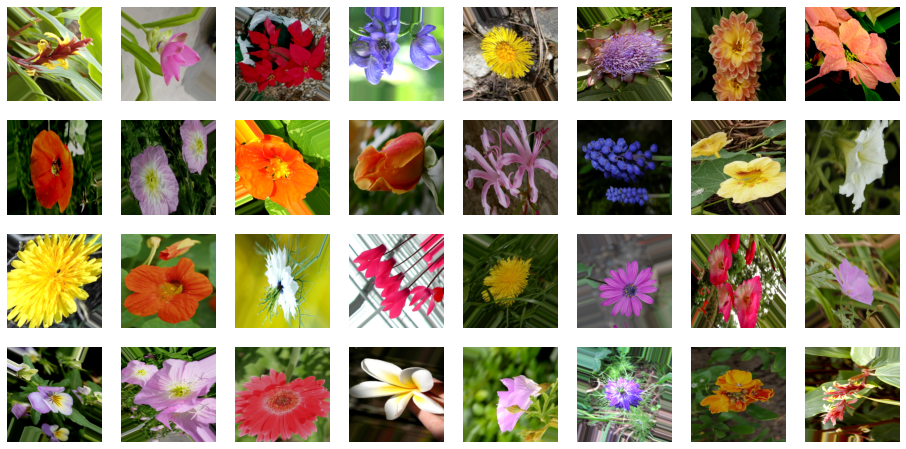

In [38]:
plt.figure(figsize=(16, 8))

batch,_  = train_generator.next()
for ind in range(BATCH_SIZE):
  image = batch[ind,:]
  ax = plt.subplot(4, 8, ind + 1)
  plt.imshow(image)
  plt.axis("off")

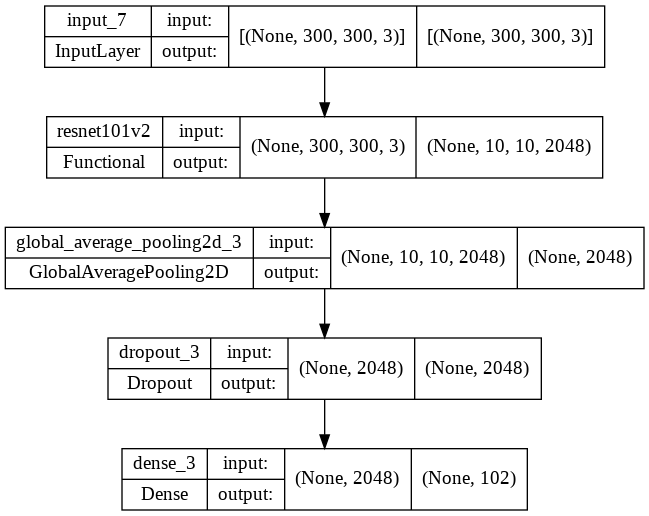

In [51]:
inputs = tf.keras.Input(shape = IMAGE_SIZE + (3,))

base_model = tf.keras.applications.ResNet101V2(
    weights='imagenet',
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
)
# base_model = tf.keras.applications.EfficientNetB3(
#     input_shape=IMAGE_SIZE + (3,),
#     include_top=False,
#     weights='imagenet',
# )
base_model.trainable = False

x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

tf.keras.utils.plot_model(model, show_shapes = True)

In [46]:
early_stoping = EarlyStopping(
    # monitor='val_sparse_categorical_accuracy', 
    monitor='val_categorical_accuracy', 
    mode='max', 
    verbose=1, 
    patience=7
)

model_checkpoint = ModelCheckpoint(
    filepath = PATH + "/best_model.hdf5",
    # monitor='val_sparse_categorical_accuracy', 
    monitor='val_categorical_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True
)

learning_rate_reduction = ReduceLROnPlateau(
    # monitor='val_sparse_categorical_accuracy', 
    monitor='val_categorical_accuracy', 
    factor=0.6, 
    min_lr=1e-7
)

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(STEP),
    loss="sparse_categorical_crossentropy",
    metrics=["SparseCategoricalAccuracy"]
)

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(STEP),
    loss="categorical_crossentropy",
    metrics=["CategoricalAccuracy"]
)

In [53]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[
        early_stoping,
        learning_rate_reduction,
        model_checkpoint,
    ],
)

Epoch 1/11
83/83 [==============================] - ETA: 0s - loss: 3.5549 - categorical_accuracy: 0.2271
Epoch 1: val_categorical_accuracy improved from -inf to 0.57368, saving model to /content/best_model.hdf5
83/83 [==============================] - 234s 3s/step - loss: 3.5549 - categorical_accuracy: 0.2271 - val_loss: 2.0973 - val_categorical_accuracy: 0.5737 - lr: 0.0010
Epoch 2/11
83/83 [==============================] - ETA: 0s - loss: 1.8545 - categorical_accuracy: 0.5745
Epoch 2: val_categorical_accuracy improved from 0.57368 to 0.71552, saving model to /content/best_model.hdf5
83/83 [==============================] - 216s 3s/step - loss: 1.8545 - categorical_accuracy: 0.5745 - val_loss: 1.3645 - val_categorical_accuracy: 0.7155 - lr: 0.0010
Epoch 3/11
83/83 [==============================] - ETA: 0s - loss: 1.3149 - categorical_accuracy: 0.6962
Epoch 3: val_categorical_accuracy improved from 0.71552 to 0.78487, saving model to /content/best_model.hdf5
83/83 [=================

In [ ]:
model = load_model(PATH+"best_model.hdf5")

## Fine Tune

In [55]:
base_model.trainable = True

best_model_layers_cnt = len(base_model.layers)

print(f'{best_model_layers_cnt//2} trainable of {best_model_layers_cnt} layers')

for layer in base_model.layers[:best_model_layers_cnt//2]:
  layer.trainable =  False

188 trainable of 377 layers


In [56]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(STEP),
    loss="categorical_crossentropy",
    metrics=["CategoricalAccuracy"]
)

In [57]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stoping, learning_rate_reduction, model_checkpoint],
)

Epoch 1/11
83/83 [==============================] - ETA: 0s - loss: 1.0457 - categorical_accuracy: 0.7117
Epoch 1: val_categorical_accuracy did not improve from 0.88258
83/83 [==============================] - 271s 3s/step - loss: 1.0457 - categorical_accuracy: 0.7117 - val_loss: 44.3794 - val_categorical_accuracy: 0.0142 - lr: 0.0010
Epoch 2/11
83/83 [==============================] - ETA: 0s - loss: 0.5534 - categorical_accuracy: 0.8429
Epoch 2: val_categorical_accuracy did not improve from 0.88258
83/83 [==============================] - 257s 3s/step - loss: 0.5534 - categorical_accuracy: 0.8429 - val_loss: 6.5329 - val_categorical_accuracy: 0.5516 - lr: 0.0010
Epoch 3/11
83/83 [==============================] - ETA: 0s - loss: 0.3906 - categorical_accuracy: 0.8847
Epoch 3: val_categorical_accuracy did not improve from 0.88258
83/83 [==============================] - 257s 3s/step - loss: 0.3906 - categorical_accuracy: 0.8847 - val_loss: 0.9934 - val_categorical_accuracy: 0.7746 - lr

In [59]:
submission = pd.read_csv('/content/DATA/flowerdata-module5/sample_submission.csv')
submission.head()

,Id,Category
0,image_00028.jpg,1
1,image_00059.jpg,1
2,image_00061.jpg,1
3,image_00063.jpg,1
4,image_00071.jpg,1


In [64]:
def predict(path: str) -> int:
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=IMAGE_SIZE
    )
    img = np.asarray(img) / 255
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    return predicted_class_index

In [ ]:
predict('/content/DATA/flowerdata-module5/test/test/image_00071.jpg')

In [63]:
model_answers = pd.DataFrame()
for file in submission['Id']:
    label = predict(f'/content/DATA/flowerdata-module5/test/test/{file}')
    model_answers = model_answers.append({
        'Id': file,
        'Category': label
    }, ignore_index=True)

model_answers = model_answers.set_index(keys = 'Id')
model_answers.to_csv('submission.csv')